In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from src.data_prep.Nifty50Dataset import Nifty50Dataset
from src.forecasting.GaussianTransformer import CustomTransformerEncoderOnly
from src.forecasting.StockSeriesForcaster import StockSeriesForecaster
from src.forecasting.StockSeriesForcasterEncoder import StockSeriesForecasterEncoder

model = CustomTransformerEncoderOnly(d_model=4, nhead=2, num_encoder_layers=6, dim_feedforward=256)

dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=60,
    prediction_horizon=1
)

split_ratio = 0.2
val_size = int(len(dataset) * split_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

forecaster = StockSeriesForecasterEncoder(model, optimizer, criterion)


[Epoch 1 | Batch 50] Loss: 4.8615
[Epoch 1 | Batch 100] Loss: 10.1726
[Epoch 1 | Batch 150] Loss: 0.3012
[Epoch 1 | Batch 200] Loss: 2.1636
[Epoch 1 | Batch 250] Loss: 5.1263
[Epoch 1 | Batch 300] Loss: 2.6376
[Epoch 1 | Batch 350] Loss: 0.6189
[Epoch 1 | Batch 400] Loss: 4.7726
[Epoch 1 | Batch 450] Loss: 0.9102
[Epoch 1 | Batch 500] Loss: 0.2548
[Epoch 1 | Batch 550] Loss: 0.3517
[Epoch 1 | Batch 600] Loss: 0.7772
[Epoch 1 | Batch 650] Loss: 0.1377
[Epoch 1 | Batch 700] Loss: 0.8731
[Epoch 1 | Batch 750] Loss: 0.5202
[Epoch 1 | Batch 800] Loss: 1.3985
[Epoch 1 | Batch 850] Loss: 0.7347
[Epoch 1 | Batch 900] Loss: 1.5067
[Epoch 1 | Batch 950] Loss: 0.4237
[Epoch 1 | Batch 1000] Loss: 3.3030
[Epoch 1 | Batch 1050] Loss: 1.6890
[Epoch 1 | Batch 1100] Loss: 0.0830
[Epoch 1 | Batch 1150] Loss: 1.2023
[Epoch 1 | Batch 1200] Loss: 2.4314
[Epoch 1 | Batch 1250] Loss: 0.6747
[Epoch 1 | Batch 1300] Loss: 0.9331
[Epoch 1 | Batch 1350] Loss: 0.7067
[Epoch 1 | Batch 1400] Loss: 0.0485
[Epoch 1 | 

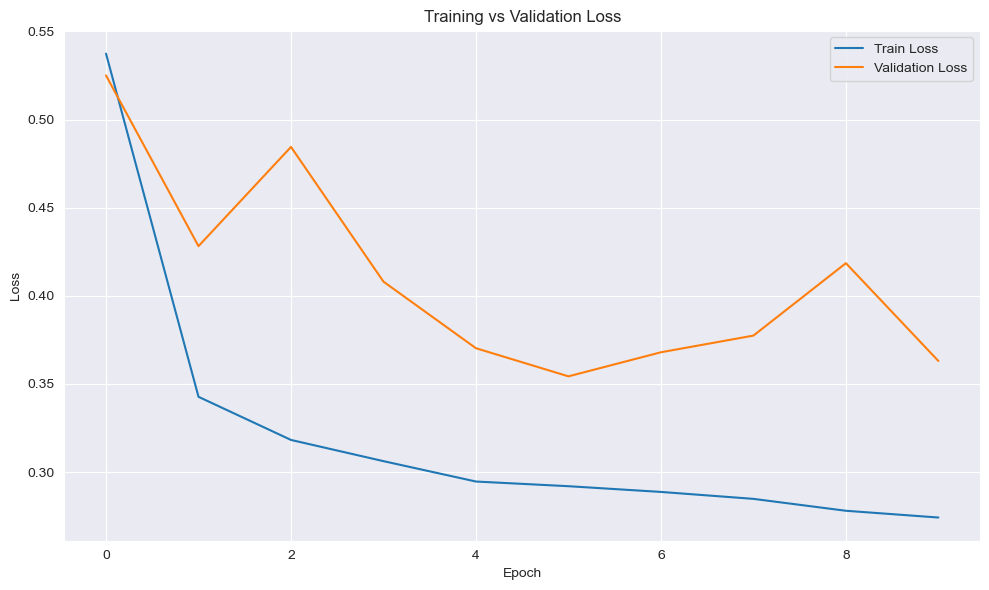

In [2]:
train_loss, val_loss = forecaster.train(train_loader, val_loader, epochs=10)

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
num_batches = 3
for i, (x, y) in enumerate(train_loader):
    if i >= num_batches:
        break
    output = forecaster.autoregressive_predict(x, max_len=20)
    print("Generated:", output)

Generated: tensor([[14211.6914, 14208.3965, 14204.3369, 14201.5039, 14200.1670, 14199.6016,
         14199.2949, 14198.9619, 14198.3320, 14196.7188, 14192.5967, 14187.3682,
         14186.3594, 14186.3633, 14186.3984, 14186.3379, 14186.1953, 14186.3008,
         14186.2715, 14186.1641],
        [13906.4375, 13912.2500, 13916.7676, 13920.5996, 13922.8135, 13923.7803,
         13924.0830, 13924.1514, 13924.2363, 13924.4453, 13924.8721, 13925.6465,
         13926.9971, 13929.2031, 13932.8975, 13935.9424, 13936.8379, 13936.9971,
         13937.0215, 13937.0469]])
Generated: tensor([[10971.6191, 10972.3379, 10974.0605, 10976.5283, 10980.1904, 10985.3135,
         10989.6475, 10991.7402, 10992.8135, 10993.5684, 10994.2793, 10995.0186,
         10995.8623, 10996.8447, 10997.9297, 10999.3340, 11001.4365, 11005.9248,
         11018.7109, 11022.4648],
        [11437.0088, 11439.0537, 11443.1670, 11447.8730, 11453.8662, 11463.3242,
         11476.6582, 11485.6084, 11489.1230, 11490.7998, 11492.07

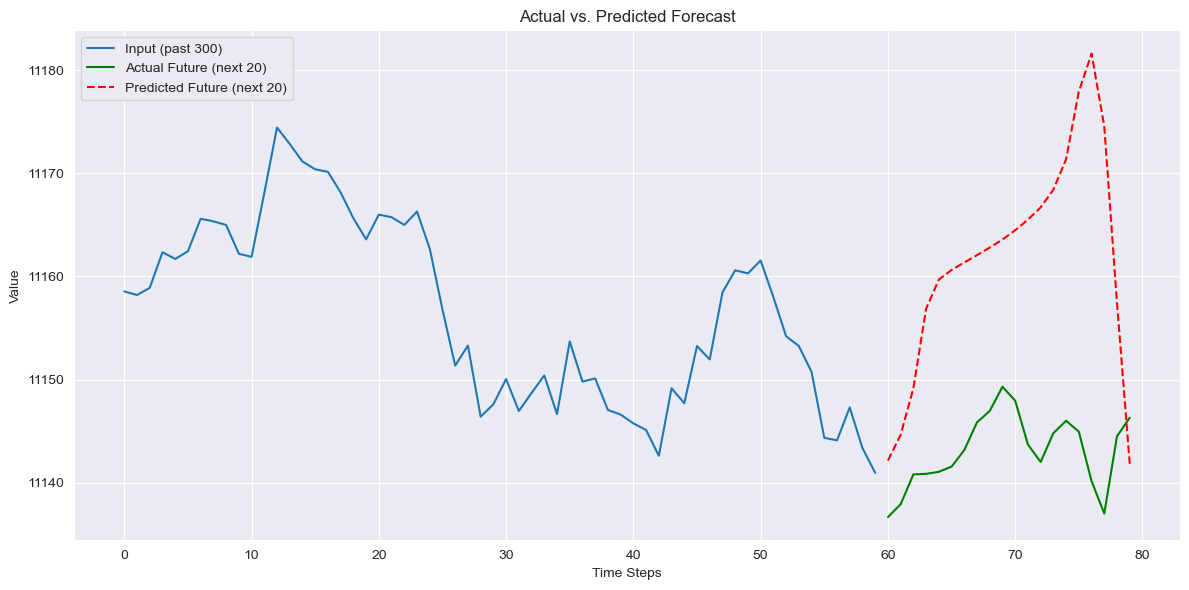

In [6]:
import matplotlib.pyplot as plt
import torch

predict_dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=80,
    prediction_horizon=1
)

data_x, data_y = predict_dataset[10000]

input_seq = data_x[:60].unsqueeze(0)
true_future = data_x[60:]

with torch.no_grad():
    predicted_future = forecaster.autoregressive_predict(input_seq, max_len=20)
predicted_future = predicted_future.squeeze().unsqueeze(-1) # Remove batch dimension

plt.figure(figsize=(12, 6))
plt.plot(range(60), input_seq.squeeze(), label='Input (past 300)')
plt.plot(range(60, 80), true_future, label='Actual Future (next 20)', color='green')
plt.plot(range(60, 80), predicted_future, label='Predicted Future (next 20)', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
torch.save(model.state_dict(), 'models_results/checkpoints/model_guassian_en_manik.pt')

In [12]:
forecaster1 = StockSeriesForecaster(model, optimizer, criterion)
train_loss, val_loss = forecaster1.train(train_loader, val_loader)

KeyboardInterrupt: 

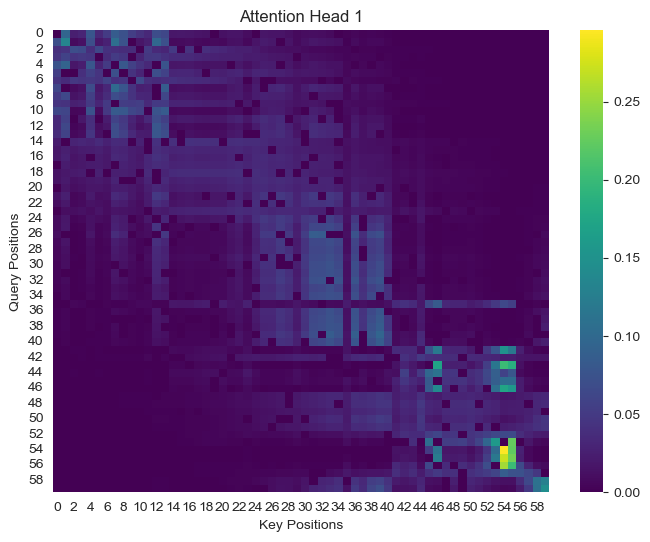

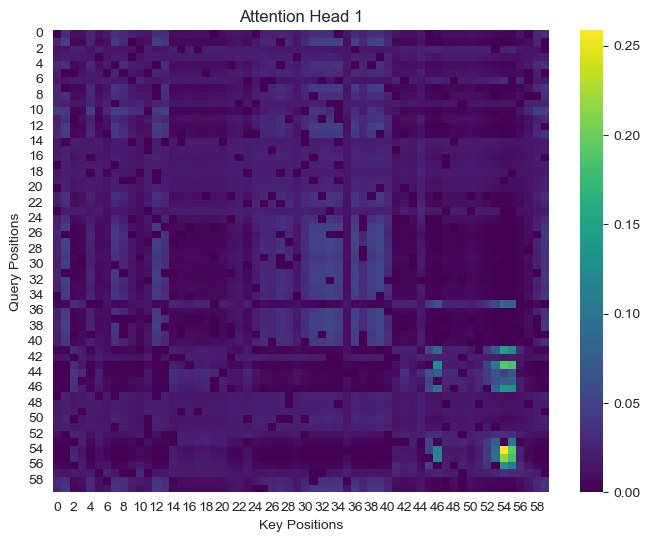

In [17]:
first_encoder_layer = model.encoder.layers[3]
attn_weights = first_encoder_layer.self_attn.guass_attn_weights_for_plot
raw_attn_weights = first_encoder_layer.self_attn.raw_attn_weights_for_plot

import matplotlib.pyplot as plt
import seaborn as sns

# Pick the first head
head_id = 0
attention = attn_weights[0, head_id].numpy()  # shape: (Tq, Tk)

plt.figure(figsize=(8, 6))
sns.heatmap(attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

head_id = 0
raw_attention = raw_attn_weights[0, head_id].numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(raw_attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()